In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle
import time
import timeit

In [ ]:
print(timeit.timeit())
# print(time.time())

In [ ]:
X_test = None
y_test = None
with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/X_test.pcl" , "rb") as f:
    X_test = pickle.load(f)

with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/y_test.pcl", "rb")as f:
    y_test = pickle.load(f)

In [ ]:
print(X_test.shape)
print(y_test.shape)

In [ ]:
X = np.empty((1, 570, 33, 1), dtype = float)
X[0,] = X_test[0]

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/keras_ecg_cnn_small_9.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
# print(input_shape.reshape(570,33,1))


In [ ]:
# inference
ret_results = []
for i,data in enumerate(X_test):  
    # print(data[i].reshape(540,33))
    # data = data.reshape(1,540,33,1)
    
    X = np.empty((1, 570, 33, 1), dtype = float)
    X[0,] = data
    start = timeit.timeit()
    input_data = X.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    end = timeit.timeit()
    ret_results.append([start, end, y_test[i].argmax(), output_data.argmax()])

print(ret_results)
with open("/Users/macbookpro/Documents/ecg_project_2/cnn_ecg_keras/cnn_ecg_testing/small_9_pc_results.pcl", "wb") as f:
    pickle.dump(ret_results, f)

0.8081705150976909


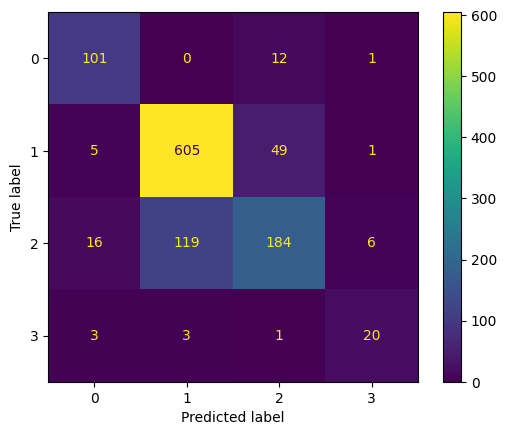

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_pred = [i[3] for i in ret_results]
y_true = [i[2] for i in ret_results]
print(accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()